In [1]:
import mat4py
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import scipy.io
import os 
from sklearn.model_selection import KFold
import math
import scipy.io
import matplotlib.pyplot as plt
from random import sample


## 
## load data

CellNames = scipy.io.loadmat('../Cells2Connectomes/CellType_Names.mat')
CellNames = CellNames['cellnames'] 

Connectomes = scipy.io.loadmat('../Cells2Connectomes/Connectomes.mat')
Connectome_direct = Connectomes['C_dir']


'''

Region volumes, in a 424 vector, to get connectivity density, divide
% each row in connectomes by each entry in the vector to get density. Units
% are in 200 micron per vertex voxels.

'''

CellType_volumn = mat4py.loadmat('../Cells2Connectomes/Regional_Volumes.mat')
CellType_volumn = CellType_volumn['region_vols']
Celltype_volumn =np.array([np.array(xi) for xi in CellType_volumn])
print(Celltype_volumn.shape)

# Nomarlize by the entry

Connectome_direct_density = Connectome_direct/Celltype_volumn

(424, 1)


In [ ]:
CellType_volumn = mat4py.loadmat('../Cells2Connectomes/Regional_Volumes.mat')
CellType_volumn = CellType_volumn['region_vols']
Celltype_volumn =np.array([np.array(xi) for xi in CellType_volumn])

In [2]:
# Import Tasic data, using the 25 cell type features

Cell_type = mat4py.loadmat('../Cells2Connectomes/Tasic_nG_606_TypeDensity.mat')
Cell_type = Cell_type['cell_type_density_nG606']
Celltype_mtx =np.array([np.array(xi) for xi in Cell_type])

# Important : normalizing via the columns

Celltype_mtx_norm =(Celltype_mtx-Celltype_mtx.min(axis=0)) / (Celltype_mtx.max(axis=0) - Celltype_mtx.min(axis=0) )



In [4]:
# random forest

# build a df to store the information

# instead use the subset, this time I am trying the whole, which might be not suitable for ML, but I just wanted a positive control
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
res_df =[]


Target = []
Dataset = []


for i in range(Celltype_mtx_norm.shape[0]):
    for j in range(Celltype_mtx_norm.shape[0]):
        # ignore self connectivity

        if i == j:
            Connectome_direct_density[i,j] = 0
            pass       
        else:

            #_Dataset_Training = np.concatenate((Dataset_Train_set[i,:],Dataset_Train_set[j,:]))
            #Dataset_Training = np.stack((Dataset_Training,_Dataset_Training))
            Dataset.append(np.concatenate((Celltype_mtx_norm[i,:],Celltype_mtx_norm[j,:])))
            Target.append(Connectome_direct_density[i,j])
            
            

Dataset = np.stack(Dataset)

capped_Target = [math.log2(x+1) for x in Target]
Target =np.array([np.array(xi) for xi in capped_Target])   




0.18307880486915215

(array([5.169e+04, 5.736e+03, 3.092e+03, 1.794e+03, 9.860e+02, 5.680e+02,
        3.100e+02, 1.120e+02, 7.000e+01, 1.800e+01]),
 array([8.00856626e-15, 7.87196061e-01, 1.57439212e+00, 2.36158818e+00,
        3.14878424e+00, 3.93598030e+00, 4.72317636e+00, 5.51037243e+00,
        6.29756849e+00, 7.08476455e+00, 7.87196061e+00]),
 <BarContainer object of 10 artists>)

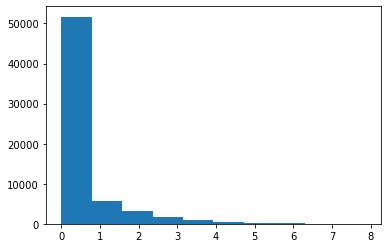

In [5]:
Dataset= Dataset[list(np.where(Target != 0)[0])]
Target = Target[list(np.where(Target != 0)[0])]

(array([    0.,  5000., 10000., 15000., 20000., 25000., 30000., 35000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

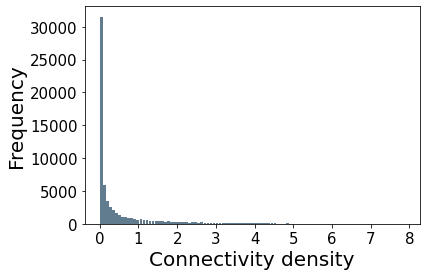

In [16]:
commutes = pd.Series(Target)

commutes.plot.hist(grid=True, bins=100, rwidth=0.9,
                   color='#607c8e')

plt.xlabel('Connectivity density', size = 20)
plt.ylabel('Frequency', size = 20)
plt.grid(alpha=0.75)
plt.xticks(size = 15)
plt.yticks(size = 15)


In [4]:
# Figure one Similarity 

import scipy.stats as stats
Connectome_direct_density_log2 = np.log2(Connectome_direct_density +1)
for i in range(424):
    Connectome_direct_density_log2[i,i]= 0
similarity_50 = np.zeros((424,424))
similarity_50_ls = []
conn_ls = []
for i in range(424):
    for j in range(424):
        similarity_50[i,j] = stats.pearsonr(Celltype_mtx_norm[i,:],Celltype_mtx_norm[j,:])[0]
        similarity_50_ls.append(similarity_50[i,j])
        conn_ls.append(Connectome_direct_density_log2[i,j])
        

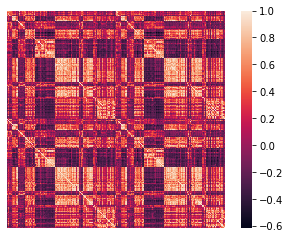

In [17]:
# similarity
import seaborn as sns
sns_plot = sns.heatmap(similarity_50,
            xticklabels=False, yticklabels=False,
            square= True)
fig = sns_plot.get_figure()

In [57]:
# Predict

predict_mtx = np.zeros((424,424))
outcome = RF_model.predict(Dataset)
outcome.shape

(64376,)

In [59]:
p = 0
for i in range(424):
    for j in range(424):
        if Connectome_direct_density_log2[i,j] !=0:
            predict_mtx[i,j] = list(outcome)[p]
            p = p + 1

64376

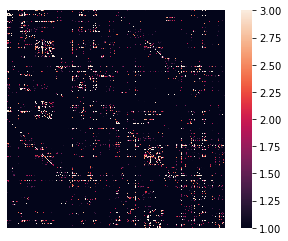

In [60]:
sns_plot = sns.heatmap(Connectome_direct_density_log2, 
            xticklabels=False, yticklabels=False,
            square= True,vmin=1, vmax = 3)

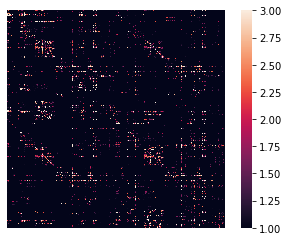

In [61]:
sns_plot = sns.heatmap(predict_mtx, 
            xticklabels=False, yticklabels=False,
            square= True,vmin=1, vmax = 3)

In [41]:
np.concatenate((Celltype_mtx_norm[i,:],Celltype_mtx_norm[j,:])).shape

(50,)

In [223]:
   
#X_train, X_test, y_train, y_test = train_test_split(Dataset, Target,test_size=.2,random_state =123)  

# in total 55 features, (25 + 25) + 1 + (1 + 1) + (1 + 1)
kf = KFold(n_splits=10, shuffle= True)
list_r2 = []
list_pearson = []
for train_index, test_index in kf.split(Dataset):
    #print(train_index)
    #print(test_index)
    sub1 = train_index#), int(len(train_index))
    sub2 = test_index#), int(len(test_index)/50))
    X_train, X_test = Dataset[sub1], Dataset[sub2]
    y_train, y_test = Target[sub1], Target[sub2]
  

    RF_model = RandomForestRegressor(n_estimators=100, max_features=20)
    RF_model.fit(X_train, y_train)
    print('Traing fit')
    Predict = RF_model.predict(X_train)
    print(r2_score(y_train, Predict))
    print('Testing fit')
    Predict = RF_model.predict(X_test)
    print(r2_score(y_test, Predict))
    print('stats.pearsonr')
    print(stats.pearsonr(y_test, Predict)[0])
    list_r2.append(r2_score(y_test, Predict))
    list_pearson.append(stats.pearsonr(y_test, Predict)[0])
    break

Traing fit
0.9415763242362523
Testing fit
0.6025009448819265
stats.pearsonr
0.7808455411868722


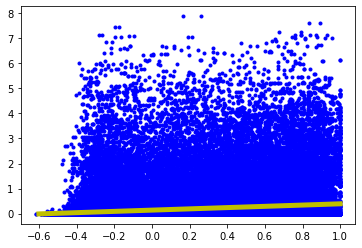

In [70]:
# correlation -1

fig, ax = plt.subplots()


#polynomial fit with degree = 2
model = np.poly1d(np.polyfit(similarity_50_ls, conn_ls, 1))

polyline = np.linspace(-0.6, 1, 50)
ax.plot(similarity_50_ls, conn_ls, 'b.')
plt.plot(polyline, model(polyline), 'y',linewidth=5)




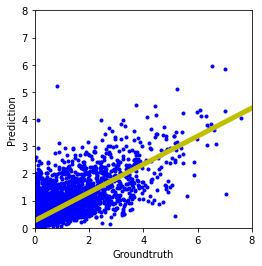

In [67]:
# correlation -2

fig, ax = plt.subplots()
plt.xlabel('Groundtruth')
plt.ylabel('Prediction')
random_index = range(len(y_test))
#polynomial fit with degree = 2
model = np.poly1d(np.polyfit(y_test, Predict, 1))

polyline = np.linspace(0, 8, 50)
ax.plot(y_test, Predict, 'b.')
plt.plot(polyline, model(polyline), 'y',linewidth=5)
ax.set_xlim(0, 8)
ax.set_ylim(0, 8)
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))


In [15]:
# Prediction the hippo regions

# load region info

def flatten_list(_2d_list):
    flat_list = []
    for element in _2d_list:
        if type(element) is list:
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

Region_maps = mat4py.loadmat('../Cells2Connectomes/Region_Names.mat')
Region_maps = Region_maps['region_names']
Region_maps = mat4py.loadmat('../Cells2Connectomes/Region_Names.mat')
Region_maps = Region_maps['region_names']

Regionmaps_df = pd.DataFrame(Region_maps,columns = ['Anno1','Anno2','Anno3'])

Region_maps_list = flatten_list(Region_maps)
Region_maps_list

Region_maps_array = np.array(Region_maps_list)
Region_maps_array_2d = np.reshape(Region_maps_array, (3,212))
Regionmaps_df['Anno1'] = Region_maps_array_2d[0]
Regionmaps_df['Anno2'] = Region_maps_array_2d[1]
Regionmaps_df['Anno3'] = Region_maps_array_2d[2]

In [16]:
# get the location for hippocampus
hippo_regions_list = list(range(25,36))+list(range(25+212,36+212))

# randomly generating the rest test dataset to 
num = 0
for i in hippo_regions_list:
    for j in hippo_regions_list:
        if Connectome_direct_density[i,j] !=0:
            num = num + 1
hippo_cases = num 
hippo_cases

256

In [184]:
Regionmaps_df.shape

(212, 3)

In [17]:
# random forest

# build a df to store the information

# instead use the subset, this time I am trying the whole, which might be not suitable for ML, but I just wanted a positive control
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
res_df =[]


test_Target = []
test_Dataset = []
train_Target = []
train_Dataset = []

# I will take 1/3 of the whole 424 regions, including the 22 hippocampus regions.
# use their non-zero interation as the test set

# I will use the rest as the training set

# 
import random 
region_num = int(((424/3) - 11*2)/2)
total_region_list= list(range(0,25)) + list(range(36, 212)) 
test_region_list = sample(total_region_list, region_num) + list(range(25,36))

for i in range(424):
    for j in range(424):
        if (i in test_region_list) or (i-212 in test_region_list):
            if  (j in test_region_list) or (j-212 in test_region_list):
                test_Dataset.append(np.concatenate((Celltype_mtx_norm[i,:],Celltype_mtx_norm[j,:])))
                test_Target.append(Connectome_direct_density[i,j])
            else:
                train_Dataset.append(np.concatenate((Celltype_mtx_norm[i,:],Celltype_mtx_norm[j,:])))
                train_Target.append(Connectome_direct_density[i,j])  
        else:
            train_Dataset.append(np.concatenate((Celltype_mtx_norm[i,:],Celltype_mtx_norm[j,:])))
            train_Target.append(Connectome_direct_density[i,j]) 
            
train_Dataset = np.stack(train_Dataset)

capped_Target = [math.log2(x+1) for x in train_Target]
train_Target =np.array([np.array(xi) for xi in capped_Target])   

#train_Dataset= train_Dataset[list(np.where(train_Target != 0)[0])]
#train_Target = train_Target[list(np.where(train_Target != 0)[0])]

test_Dataset = np.stack(test_Dataset)

capped_Target = [math.log2(x+1) for x in test_Target]
test_Target =np.array([np.array(xi) for xi in capped_Target])   

#test_Dataset= test_Dataset[list(np.where(test_Target != 0)[0])]
#test_Target = test_Target[list(np.where(test_Target != 0)[0])]

In [18]:
'''
test_Dataset =[]
test_Target = []
for i in range(25,36):
    for j in range(25,36):
        test_Dataset.append(np.concatenate((Celltype_mtx_norm[i,:],Celltype_mtx_norm[j,:])))
        test_Target.append(Connectome_direct_density[i,j])
'''

In [19]:
RF_model = RandomForestRegressor(n_estimators=100, max_features=20)
RF_model.fit(train_Dataset, train_Target)
print('Traing fit')
Predict = RF_model.predict(train_Dataset)
print(r2_score(train_Target, Predict))


print('Test fit')
Predict = RF_model.predict(test_Dataset)
print(r2_score(test_Target, Predict))

Traing fit
0.9134300723930141
Test fit
-0.09886715467005214


In [14]:
test_Target = []
test_Dataset = []

for i in list(range(25,36))+list(range(25+212,36+212)):
    for j in list(range(25,36))+list(range(25+212,36+212)):
        test_Dataset.append(np.concatenate((Celltype_mtx_norm[i,:],Celltype_mtx_norm[j,:])))
        test_Target.append(Connectome_direct_density[i,j])
        
test_Dataset = np.stack(test_Dataset)
capped_Target = [math.log2(x+1) for x in test_Target]
test_Target =np.array([np.array(xi) for xi in capped_Target])   

#test_Dataset= test_Dataset[list(np.where(test_Target != 0)[0])]
#test_Target = test_Target[list(np.where(test_Target != 0)[0])]

print('Test fit')
Predict = RF_model.predict(test_Dataset)
print(r2_score(test_Target, Predict))

Test fit
-0.24259330085770303


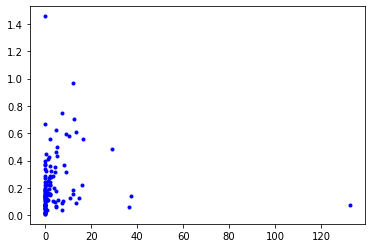

In [20]:
plt.plot(test_Target, Predict, 'b.')

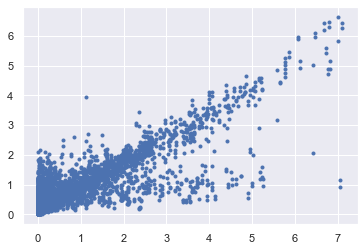

In [216]:
plt.plot(test_Target, Predict, 'b.')

In [209]:
# after the training, visulize iton the hippocampus, left part
predict = []
groundtruth = []
hippo_predict = np.zeros((11,11))
for i in range(25,36):
    for j in range(25,36): 
        if Connectome_direct_density_log2[i,j] == 0:
            pass
        else: 
            
            hippo_predict[i-25,j-25] = RF_model.predict(np.concatenate((Celltype_mtx_norm[i,:],
                                                             Celltype_mtx_norm[j,:])).reshape(1,50))
            predict.append(hippo_predict[i-25,j-25])
            groundtruth.append(Connectome_direct_density_log2[i,j])

In [206]:
RF_model.predict(np.concatenate((Celltype_mtx_norm[i,:], Celltype_mtx_norm[j,:])).reshape(1,50))

array([1.28454424])

In [202]:
2**1.6

3.0314331330207964

<AxesSubplot:>

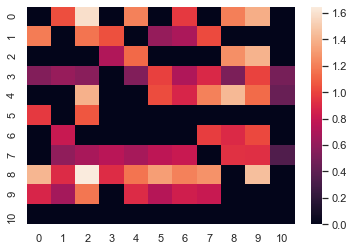

In [213]:
sns.heatmap(hippo_predict)

<AxesSubplot:>

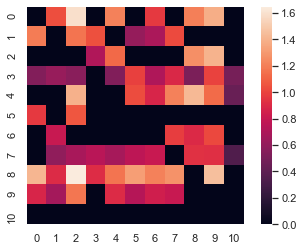

In [214]:
sns.heatmap(hippo_predict, square = True)

<AxesSubplot:>

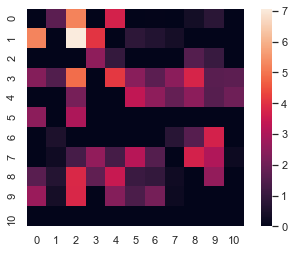

In [179]:
sns.heatmap(Connectome_direct_density_log2[26:37,26:37], square = True)

<AxesSubplot:>

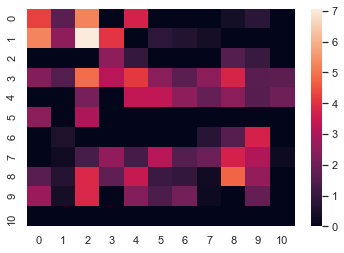

In [169]:
sns.heatmap(truth['mtx'])

In [172]:
np.where(Connectome_direct_density_log2 ==  truth['mtx'][0][1])

(array([ 26, 238]), array([ 27, 239]))

In [177]:
Connectome_direct_density_log2[26,27]

1.6564985971749355

(array([ 26, 238]), array([ 28, 240]))

(array([  0,   0,   0, ..., 423, 423, 423]),
 array([  0,   1,   2, ..., 418, 422, 423]))

In [173]:
truth['mtx'][0][1]

1.6564985971749355

In [175]:
truth['mtx'][0][2]

5.224557687726789

In [157]:
truth = scipy.io.loadmat('Hippo_truth.mat')
truth['mtx'].shape

(11, 11)

<ipython-input-225-de53fd8c60f7>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels(changes, fontsize = 15)
<ipython-input-225-de53fd8c60f7>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_yticklabels(changes, fontsize = 15)
<ipython-input-225-de53fd8c60f7>:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax5.set_xticklabels(changes, fontsize = 15)
<ipython-input-225-de53fd8c60f7>:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax5.set_yticklabels(changes, fontsize = 15)


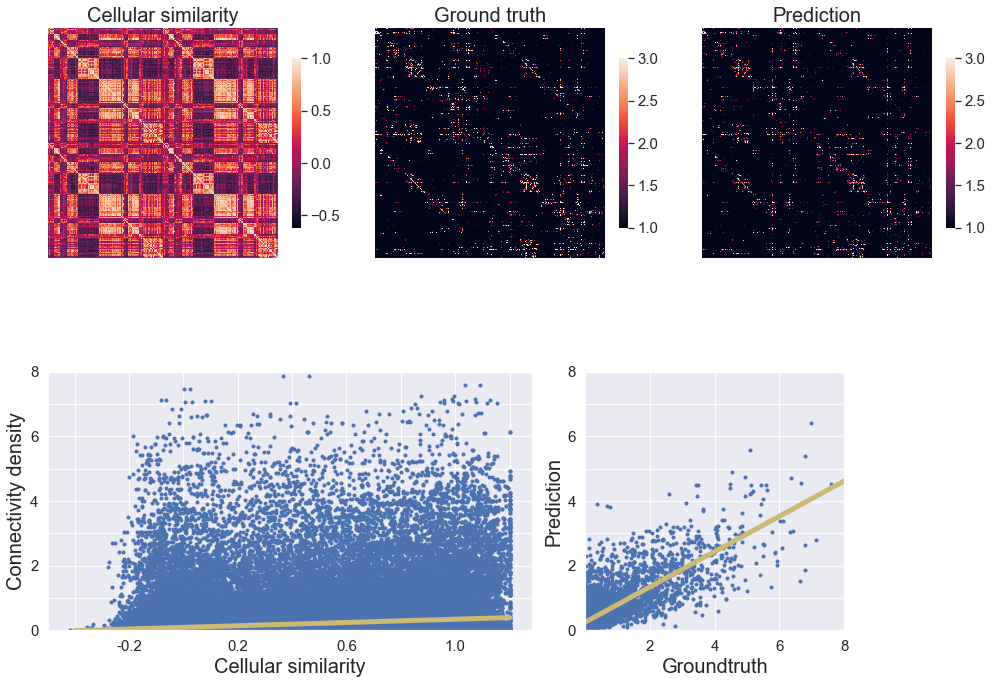

In [225]:
fig = plt.figure(figsize=(14, 15))
if 1 == 1:
    ax1 = plt.subplot2grid((14, 15), (0, 0), colspan=5, rowspan = 5)
    sns.heatmap(similarity_50, 
            xticklabels=False, yticklabels=False,
            square= True, ax = ax1,
               cbar_kws={"shrink": .5,} )
    sns.set(font_scale=1)
    #cbar1 = ax1.collections[0].colorbar
    #cbar1.set_ticks(size = 18)
    ax1.set_title('Cellular similarity', fontsize = 20)
    #ax1.figure.axes[-1].set_ylabel('Accuracy %', size=20)
    ax1.figure.axes[-1].tick_params(axis="both", labelsize=15)
if 1== 1:
    ax2 = plt.subplot2grid((14, 15), (0, 5), colspan=5, rowspan = 5)
    sns_plot = sns.heatmap(Connectome_direct_density_log2, 
            xticklabels=False, yticklabels=False,
            square= True,vmin=1, vmax = 3, ax = ax2, 
                           cbar_kws = {"shrink": .5},)
    ax2.set_title('Ground truth', fontsize = 20)
    ax2.figure.axes[-1].tick_params(axis="both", labelsize=15)
if 1 ==1:
    
    ax3 = plt.subplot2grid((14, 15), (0, 10), colspan=5, rowspan = 5)
    sns_plot = sns.heatmap(predict_mtx, 
            xticklabels=False, yticklabels=False,
            square= True,vmin=1, vmax = 3, ax = ax3, 
                           cbar_kws = {"shrink": .5},)
    ax3.set_title('Prediction', fontsize = 20)
    ax3.figure.axes[-1].tick_params(axis="both", labelsize=15)
if 1 ==1:
    
    ax4 = plt.subplot2grid((14, 15), (5, 0), colspan=8, rowspan = 4)
    model = np.poly1d(np.polyfit(similarity_50_ls, conn_ls, 1))

    polyline = np.linspace(-0.6, 1, 50)
    ax4.plot(similarity_50_ls, conn_ls, 'b.')
    plt.plot(polyline, model(polyline), 'y',linewidth=5)
    changes = ['-0.6', '', '-0.2','', '0.2',  '', '0.6', '','1.0']
    ax4.set_xticklabels(changes, fontsize = 15)
    ax4.set_ylim(0, 8)
    changes = ['0', '', '2','', '4',  '', '6', '','8']
    ax4.set_yticklabels(changes, fontsize = 15)
    plt.xlabel('Cellular similarity', fontsize = 20)
    plt.ylabel('Connectivity density', fontsize = 20)
if 1==1:
    ax5 = plt.subplot2grid((14, 15), (5, 8), colspan=5, rowspan = 4)
    plt.xlabel('Groundtruth', fontsize = 20)
    plt.ylabel('Prediction', fontsize = 20)
    random_index = range(len(y_test))
    #polynomial fit with degree = 2
    model = np.poly1d(np.polyfit(y_test, Predict, 1))

    polyline = np.linspace(0, 8, 50)
    ax5.plot(y_test, Predict, 'b.')
    plt.plot(polyline, model(polyline), 'y',linewidth=5)
    ax5.set_xlim(0, 8)
    ax5.set_ylim(0, 8)
    

    x0,x1 = ax5.get_xlim()
    y0,y1 = ax5.get_ylim()
    changes = ['', '2', '4', '6', '8']
    
    ax5.set_xticklabels(changes, fontsize = 15)
    changes = ['0', '', '2','', '4',  '', '6', '','8']
    ax5.set_yticklabels(changes, fontsize = 15)
    ax5.set_aspect(abs(x1-x0)/abs(y1-y0))
    


fig.tight_layout()

### without excluding the zero values

In [3]:
# random forest

# build a df to store the information

# instead use the subset, this time I am trying the whole, which might be not suitable for ML, but I just wanted a positive control
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
res_df =[]


Target = []
Dataset = []


for i in range(Celltype_mtx_norm.shape[0]):
    for j in range(Celltype_mtx_norm.shape[0]):
        # ignore self connectivity

        if i == j:
            Connectome_direct_density[i,j] = 0
            pass       
        else:

            #_Dataset_Training = np.concatenate((Dataset_Train_set[i,:],Dataset_Train_set[j,:]))
            #Dataset_Training = np.stack((Dataset_Training,_Dataset_Training))
            Dataset.append(np.concatenate((Celltype_mtx_norm[i,:],Celltype_mtx_norm[j,:])))
            Target.append(Connectome_direct_density[i,j])
            
            

Dataset = np.stack(Dataset)

capped_Target = [math.log2(x+1) for x in Target]
Target =np.array([np.array(xi) for xi in capped_Target])   

#Dataset= Dataset[list(np.where(Target != 0)[0])]
#Target = Target[list(np.where(Target != 0)[0])]

In [5]:
   
#X_train, X_test, y_train, y_test = train_test_split(Dataset, Target,test_size=.2,random_state =123)  

# in total 55 features, (25 + 25) + 1 + (1 + 1) + (1 + 1)
kf = KFold(n_splits=10, shuffle= True)
list_r2 = []
list_pearson = []
for train_index, test_index in kf.split(Dataset):
    sub1 = train_index#), int(len(train_index))
    sub2 = test_index#), int(len(test_index)/50))
    X_train, X_test = Dataset[sub1], Dataset[sub2]
    y_train, y_test = Target[sub1], Target[sub2]
  

    RF_model = RandomForestRegressor(n_estimators=100, max_features=20)
    RF_model.fit(X_train, y_train)
    print('Traing fit')
    Predict = RF_model.predict(X_train)
    print(r2_score(y_train, Predict))
    print('Testing fit')
    Predict = RF_model.predict(X_test)
    print(r2_score(y_test, Predict))
    list_r2.append(r2_score(y_test, Predict))
    


Traing fit
0.9142048870265955
Testing fit
0.38543221023150587
Traing fit
0.9146769151138173
Testing fit
0.38025836305975047
Traing fit
0.9140607158388414
Testing fit
0.40042708855486087
Traing fit
0.9141283630540454
Testing fit
0.41138700037623777
Traing fit
0.9148819410900442
Testing fit
0.3877561767692165
Traing fit
0.9152010720314284
Testing fit
0.3971958887576814
Traing fit
0.9150444913180947
Testing fit
0.36685624339511214
Traing fit
0.9143680005619544
Testing fit
0.3925699856613424
Traing fit
0.9148249451227053
Testing fit
0.40091075058638015
Traing fit
0.9142229041109592
Testing fit
0.418056530200854


In [6]:
import statistics as stat

stat.mean(list_r2)

0.39408502375929416

In [8]:
### Different regressor methods



# build a df to store the information

# instead use the subset, this time I am trying the whole, which might be not suitable for ML, but I just wanted a positive control
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
res_df =[]


Target = []
Dataset = []


for i in range(Celltype_mtx_norm.shape[0]):
    for j in range(Celltype_mtx_norm.shape[0]):
        # ignore self connectivity

        if i == j:
            Connectome_direct_density[i,j] = 0
            pass       
        else:

            #_Dataset_Training = np.concatenate((Dataset_Train_set[i,:],Dataset_Train_set[j,:]))
            #Dataset_Training = np.stack((Dataset_Training,_Dataset_Training))
            Dataset.append(np.concatenate((Celltype_mtx_norm[i,:],Celltype_mtx_norm[j,:])))
            Target.append(Connectome_direct_density[i,j])
            
            

Dataset = np.stack(Dataset)

capped_Target = [math.log2(x+1) for x in Target]
Target =np.array([np.array(xi) for xi in capped_Target])   

Dataset= Dataset[list(np.where(Target != 0)[0])]
Target = Target[list(np.where(Target != 0)[0])]

In [10]:
from sklearn import linear_model

import sklearn.metrics as metrics
import statistics as stats
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
#X_train, X_test, y_train, y_test = train_test_split(Dataset, Target,test_size=.2,random_state =123)  
p = 0
# in total 55 features, (25 + 25) + 1 + (1 + 1) + (1 + 1)
kf = KFold(n_splits=10, shuffle= True)
list_r2 = []
list_rmse = []

for train_index, test_index in kf.split(Dataset):
    p = p + 1
    #print(train_index)
    #print(test_index)
    sub1 = train_index#), int(len(train_index))
    sub2 = test_index#), int(len(test_index)/50))
    X_train, X_test = Dataset[sub1], Dataset[sub2]
    y_train, y_test = Target[sub1], Target[sub2]
  
    print(p)
    
    #reg = LazyRegressor(verbose=1, predictions=True,ignore_warnings=False, custom_metric=None)
    #models, predictions = reg.fit(X_train, X_test, y_train, y_test)
    #print(models)
    
    #RF_model = RandomForestRegressor(n_estimators=100,max_features = 60,max_depth=20,min_samples_split =3)#,warm_start = True)  # height
    
    #RF_model = RandomForestClassifier(n_estimators=100, max_features = 20, max_depth= 30)
    regr = linear_model.Ridge(solver = 'svd', alpha=1e-6,max_iter=10000,tol=1e-4, 
                                        random_state=42)
    #regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    
    #print('Traing fit')
    Predict = regr.predict(X_train)
    print(r2_score(y_train, Predict))
    #print((y_train, Predict))
    #print('Testing fit')
    Predict = regr.predict(X_test)
    list_r2.append(r2_score(y_test, Predict))
    print(rmse(y_test, Predict))
    list_rmse.append(rmse(y_test, Predict))

    
    
    #print(r2_score(y_test, Predict))
    #list_r2.append(r2_score(y_test, Predict))




1
0.0621707449215565
0.9427131961165348
2
0.06213734652462566
0.8820934829830048
3
0.0619389073029728
0.9086703980362003
4
0.06137396146792795
0.9123567948230162
5
0.062299288132534936
0.898742802689955
6
0.06070544997860183
0.909082446726649
7
0.06158200699036365
0.9061895863732699
8
0.06091149525166428
0.9346343583579053
9
0.06213260800300979
0.9165498852417314
10
0.06022338130757532
0.9020490181101527


In [15]:
print(stats.mean(list_r2))

print(stats.mean(list_rmse))

0.059782391044365946
0.9113678334709728


0.911308196945842

### Lasso

In [17]:
from sklearn import linear_model

import sklearn.metrics as metrics
import statistics as stats
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
#X_train, X_test, y_train, y_test = train_test_split(Dataset, Target,test_size=.2,random_state =123)  
p = 0
# in total 55 features, (25 + 25) + 1 + (1 + 1) + (1 + 1)
kf = KFold(n_splits=10, shuffle= True)
list_r2 = []
list_rmse = []

for train_index, test_index in kf.split(Dataset):
    p = p + 1
    #print(train_index)
    #print(test_index)
    sub1 = train_index#), int(len(train_index))
    sub2 = test_index#), int(len(test_index)/50))
    X_train, X_test = Dataset[sub1], Dataset[sub2]
    y_train, y_test = Target[sub1], Target[sub2]
  
    print(p)
    
    #reg = LazyRegressor(verbose=1, predictions=True,ignore_warnings=False, custom_metric=None)
    #models, predictions = reg.fit(X_train, X_test, y_train, y_test)
    #print(models)
    
    #RF_model = RandomForestRegressor(n_estimators=100,max_features = 60,max_depth=20,min_samples_split =3)#,warm_start = True)  # height
    
    #RF_model = RandomForestClassifier(n_estimators=100, max_features = 20, max_depth= 30)
    Lasso = linear_model.Lasso( alpha=1e-6,max_iter=10000,tol=1e-4, 
                                        random_state=42)
    #regr = linear_model.LinearRegression()
    Lasso.fit(X_train, y_train)
    
    #print('Traing fit')
    Predict = Lasso.predict(X_train)
    print(r2_score(y_train, Predict))
    #print((y_train, Predict))
    #print('Testing fit')
    Predict = regr.predict(X_test)
    list_r2.append(r2_score(y_test, Predict))
    print(rmse(y_test, Predict))
    list_rmse.append(rmse(y_test, Predict))

    
    
    #print(r2_score(y_test, Predict))
    #list_r2.append(r2_score(y_test, Predict))





1
0.06055849006491232
0.8862313585760159
2
0.06265858278607461
0.8649317649443446
3
0.06115254326580777
0.9438610018526998
4
0.0628873618989404
0.9002599288795117
5
0.0600235324700501
0.9385334904508813
6
0.062228671993960094
0.9166148915809724
7
0.061233916821552214
0.9146970856114333
8
0.06175871953906342
0.903990563876694
9
0.0611441796009311
0.8926126394277721
10
0.06186869298806208
0.9430073504011556
